# Predicting product cancelations for sales retention
Investigate machine learning techniques to predict the likely-hood of a product cancellation based on existing sales and amount spent in annual maintenance. To enable the targeting of retention resources and offers to those customers who are predicted as at risk. 

In [1]:
# get updated version on pandas
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
if LooseVersion(pd.__version__) < LooseVersion("0.22.0"):
    !pip install --upgrade pandas
    pd.__version__
    print("pandas version was: " + pd.__version__ + " It has been updated, please restart the kernel")
else:
    print("pandas version is high enough")

pandas version is high enough


In [2]:
#some extra libs that we need in the page:
#!pip install hypopt
#!pip install --upgrade seaborn
!pip install pdtransform
!pip install tabulate
!pip install seaborn==0.9.0 

In [4]:
# setup the notebook and import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve,
    accuracy_score
    )
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, classification_report,make_scorer
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer,QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
#from sklearn import cross_validation
from pdtransform import DFTransform, DFFeatureUnion
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
%matplotlib inline

#Get the data from the same folder as the notebook and test the pandas version
csvData = './ResultsGrid.csv'
isCancelledKey = 'isCancelled'
customerIdKey = 'customerId'
adminAreaKey = 'administrativeArea'
subCountryKey = 'subCountryArea'
countryKey = 'country'
avgDaysToPay='avgDaysToPay'

In [36]:
#seaborn defaults - see http://www.jesshamrick.com/2016/04/13/reproducible-plots/
sns.set_context("paper") 
# Set the font to be serif, rather than sans
sns.set(font='serif')
# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})
# configure seaborn https://seaborn.pydata.org/
sns.set(color_codes=True)
colors = ["amber", "windows blue", "red","green", "grey", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

# The machine learning pipeline
![](https://cdn-images-1.medium.com/max/1600/1*2T5rbjOBGVFdSvtlhCqlNg.png)

In [6]:
pd.set_option('display.max_rows', 100)
dataFrame = pd.read_csv(csvData)
isCancelledIndex = dataFrame.columns.get_loc(isCancelledKey)
dataFrame.head()

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate
0,215093,159.2,159.2,0.0,0.0,0.0,0.0,1,-1,0.0,...,False,False,False,False,False,True,none,none,United Kingdom,01/06/2018
1,215092,239.0,239.0,0.0,0.0,0.0,0.0,2,10,0.0,...,False,False,False,False,False,True,none,none,United Kingdom,25/05/2018
2,215091,239.0,239.0,0.0,0.0,0.0,0.0,2,33,0.0,...,False,False,False,False,False,True,WORCESTERSHIRE,West Midlands,United Kingdom,25/05/2018
3,215090,125.0,125.0,0.0,0.0,0.0,0.0,2,35,0.0,...,False,False,False,False,False,True,BEXLEY,London,United Kingdom,24/05/2018
4,215089,125.0,125.0,0.0,0.0,0.0,0.0,2,35,0.0,...,False,False,False,False,False,True,BEXLEY,London,United Kingdom,24/05/2018


In [132]:
dataFrame = dataFrame.infer_objects()
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676 entries, 0 to 4675
Data columns (total 27 columns):
customerId              4676 non-null int64
amountTotal             4676 non-null float64
salesTotal              4676 non-null float64
annualTotal             4676 non-null float64
monthlyTotalProduct1    4676 non-null float64
monthlyTotalProduct2    4676 non-null float64
extraItemsTotal         4676 non-null float64
monthsSinceStarted      4676 non-null int64
avgDaysToPay            4676 non-null int64
creditedAmount          4676 non-null float64
isCancelled             4676 non-null bool
hasProduct1             4676 non-null bool
hasProduct2             4676 non-null bool
hasProduct3             4676 non-null bool
hasProduct4             4676 non-null bool
hasProduct5             4676 non-null bool
hasProduct6             4676 non-null bool
hasProduct7             4676 non-null bool
hasProduct8             4676 non-null bool
hasProduct9             4676 non-null bool
hasProduc

In [7]:
dataFrame.describe(include='all')

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate
count,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,...,4676,4676,4676,4676,4676,4676,4676,4676,4676,4676
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,217,15,11,1400
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,none,North West,United Kingdom,30/11/2009
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4663,4646,4675,3991,4616,3293,244,1040,4550,82
mean,46900.834474,8199.874506,1091.890119,2638.875297,1719.273641,2563.909930,185.912380,62.047049,55.949102,201.173556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,67281.977821,13508.391594,2142.141606,4175.236029,4170.699589,6703.879866,941.121206,46.325072,184.911668,1290.280499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-10162.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3808.750000,657.000000,149.000000,240.000000,0.000000,0.000000,0.000000,22.000000,23.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,11919.500000,2650.000000,310.000000,1000.000000,0.000000,121.415000,0.000000,54.000000,41.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,38661.000000,9256.892500,897.000000,3150.000000,964.875000,2123.912500,0.000000,96.000000,67.250000,1.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Describe the boolean cols, including the dependant `isCancelled` col
#dataFrame.describe(include=['bool'])
booltypes = dataFrame.select_dtypes(include=['bool'])
booltypes.apply(pd.Series.value_counts)

,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
False,2600,2798,1802,4676.0,4372,4675,4676.0,4663,4646,4675,3991,4616,3293
True,2076,1878,2874,NaN,304,1,NaN,13,30,1,685,60,1383


In [9]:
# from https://stackoverflow.com/a/44702024
nans = lambda df: df[df.isnull().any(axis=1)]
nans(dataFrame)

# Remove if found above - none found...
# drop the rows where values are nan and return the new dataframe
# dataFrame = dataFrame.dropna(axis=0)

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate


In [10]:
# Find correlations and sort
# dataFrame.corr()[isCancelledKey].sort_values()
corr_matrix = dataFrame.corr()
corr_matrix[isCancelledKey].sort_values(ascending=False)

isCancelled             1.000000
hasProduct2             0.247663
hasProduct1             0.189850
hasProduct4             0.087349
creditedAmount          0.064485
salesTotal              0.030795
hasProduct7             0.026391
avgDaysToPay            0.021927
monthlyTotalProduct1    0.016987
hasProduct5            -0.013069
hasProduct9            -0.013069
annualTotal            -0.022727
hasProduct8            -0.034066
amountTotal            -0.064680
hasProduct11           -0.067456
monthsSinceStarted     -0.068659
monthlyTotalProduct2   -0.117760
extraItemsTotal        -0.134093
customerId             -0.163728
hasProduct10           -0.310549
hasProduct12           -0.369712
hasProduct3                  NaN
hasProduct6                  NaN
Name: isCancelled, dtype: float64

In [11]:
# heatmap of correlations
corrDf = dataFrame.drop(['firstInvoiceDate',customerIdKey,adminAreaKey,subCountryKey,countryKey], axis=1)
corr = corrDf.corr()
corrDf.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\Users\nathan\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
amountTotal,1.0,0.58,0.78,0.8,0.82,0.18,0.63,-0.087,0.11,-0.065,0.49,0.2,nan,0.19,-0.0035,nan,0.012,0.15,-0.0078,0.027,-0.036,-0.23
salesTotal,0.58,1.0,0.56,0.36,0.26,0.12,0.27,-0.064,0.17,0.031,0.34,0.1,nan,0.089,-0.0075,nan,0.0058,0.4,-0.0048,-0.0059,-0.028,-0.15
annualTotal,0.78,0.56,1.0,0.58,0.4,0.11,0.62,-0.083,0.16,-0.023,0.46,0.16,nan,0.17,0.0081,nan,0.012,0.38,-0.0072,-0.011,-0.042,-0.24
monthlyTotalProduct1,0.8,0.36,0.58,1.0,0.5,0.055,0.57,-0.089,0.055,0.017,0.5,0.16,nan,0.2,-0.0059,nan,-0.014,-0.033,-0.006,-0.022,-0.038,-0.21
monthlyTotalProduct2,0.82,0.26,0.4,0.5,1.0,0.079,0.42,-0.046,0.021,-0.12,0.27,0.15,nan,0.11,-0.0056,nan,0.016,-0.031,-0.0056,0.071,-0.014,-0.13
extraItemsTotal,0.18,0.12,0.11,0.055,0.079,1.0,0.14,-0.012,0.048,-0.13,0.067,0.11,nan,0.029,-0.0029,nan,0.058,-0.016,-0.0023,0.049,-0.0056,-0.024
monthsSinceStarted,0.63,0.27,0.62,0.57,0.42,0.14,1.0,-0.081,0.064,-0.069,0.43,0.44,nan,0.17,0.028,nan,-0.021,-0.036,0.035,-0.039,-0.05,-0.33
avgDaysToPay,-0.087,-0.064,-0.083,-0.089,-0.046,-0.012,-0.081,1.0,0.052,0.022,-0.12,-0.044,nan,-0.045,-0.003,nan,-0.0099,0.013,0.0048,-0.014,0.004,0.078
creditedAmount,0.11,0.17,0.16,0.055,0.021,0.048,0.064,0.052,1.0,0.064,0.049,0.037,nan,0.021,-0.0023,nan,0.0068,0.21,0.0034,-0.021,-0.013,-0.051
isCancelled,-0.065,0.031,-0.023,0.017,-0.12,-0.13,-0.069,0.022,0.064,1.0,0.19,0.25,nan,0.087,-0.013,nan,0.026,-0.034,-0.013,-0.31,-0.067,-0.37


In [12]:
corrDf.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\Users\nathan\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
amountTotal,1.0,0.49,0.9,0.7,0.69,0.17,0.8,-0.18,0.24,0.033,0.58,0.43,nan,0.16,0.0064,nan,0.003,0.1,-0.0088,-0.002,-0.039,-0.38
salesTotal,0.49,1.0,0.36,0.34,0.3,0.16,0.23,0.013,0.16,-0.12,0.25,0.11,nan,0.085,-0.02,nan,-0.031,0.13,0.0028,0.081,0.011,0.057
annualTotal,0.9,0.36,1.0,0.65,0.55,0.13,0.8,-0.19,0.26,0.098,0.55,0.39,nan,0.19,0.016,nan,0.026,0.089,-0.0063,-0.05,-0.052,-0.38
monthlyTotalProduct1,0.7,0.34,0.65,1.0,0.36,-0.021,0.56,-0.37,0.13,0.13,0.83,0.25,nan,0.27,0.0092,nan,0.0017,-0.055,0.0085,-0.033,-0.053,-0.34
monthlyTotalProduct2,0.69,0.3,0.55,0.36,1.0,0.18,0.66,0.037,0.19,-0.14,0.22,0.48,nan,0.055,-0.015,nan,-0.023,-0.085,-0.015,0.15,0.011,-0.26
extraItemsTotal,0.17,0.16,0.13,-0.021,0.18,1.0,0.17,0.099,0.2,-0.17,-0.0012,0.19,nan,-0.014,-0.005,nan,0.022,-0.02,0.037,0.096,0.015,-0.047
monthsSinceStarted,0.8,0.23,0.8,0.56,0.66,0.17,1.0,-0.039,0.24,-0.019,0.41,0.5,nan,0.15,0.023,nan,-0.024,-0.033,0.024,-0.061,-0.055,-0.36
avgDaysToPay,-0.18,0.013,-0.19,-0.37,0.037,0.099,-0.039,1.0,0.17,-0.097,-0.39,-0.0075,nan,-0.15,-0.015,nan,-0.043,0.056,0.019,0.03,0.026,0.17
creditedAmount,0.24,0.16,0.26,0.13,0.19,0.2,0.24,0.17,1.0,0.12,0.087,0.21,nan,0.048,-0.0085,nan,0.0093,0.028,0.027,-0.0014,-0.01,-0.12
isCancelled,0.033,-0.12,0.098,0.13,-0.14,-0.17,-0.019,-0.097,0.12,1.0,0.19,0.25,nan,0.087,-0.013,nan,0.026,-0.034,-0.013,-0.31,-0.067,-0.37


### Pipeline

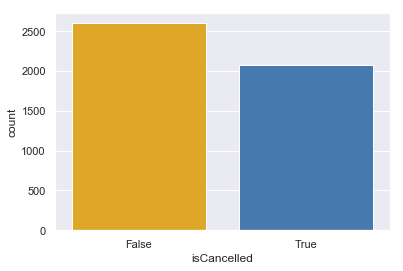

In [37]:
bar = sns.countplot(x=isCancelledKey,data=dataFrame)
fig = bar.get_figure()
fig.savefig('dependantSpread.eps', format='eps')

In [38]:
def getTrainTestSplit(df):
    #remove the dependant variable and columns that have no value in training
    data = df.drop([isCancelledKey], axis=1)
    # Set monthsSinceStarted and avgDaysToPay to 0 if negative
    df.loc[:, ['monthsSinceStarted','avgDaysToPay']]  = df[['monthsSinceStarted','avgDaysToPay']].clip(lower=0)
    X_train, X_test, y_train, y_test = train_test_split( data, df[isCancelledKey], test_size=0.33, random_state=42, stratify=df[isCancelledKey])
    
    print('y_train class distribution')
    print(y_train.value_counts(normalize=True))
    print('y_test class distribution')
    print(y_test.value_counts(normalize=True))
    
    return X_train, X_test, y_train, y_test

In [51]:
def printConfusionMatrix(confusion_matrix, printName = "", figsize = (10,7), fontsize=14):
    classNames = ['false', 'true']
    df_cm = pd.DataFrame(
        confusion_matrix, index=classNames, columns=classNames, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if(printName != ""):
        confusionMatrixfig = heatmap.get_figure()
        confusionMatrixfig.savefig(printName, format='eps')
    
    return fig

In [40]:
def printDescribe(afterString, df):
    print(f"{afterString} - Number of features {len(df.columns)}")

In [41]:
def getOneHotEncodeData(df):
    categoryFeatures = [subCountryKey] #[adminAreaKey, subCountryKey,countryKey]
    oneHotDataframe = pd.get_dummies(df,columns=categoryFeatures, dummy_na=True)
    return oneHotDataframe

In [67]:
def printClassificationReport(y_test, y_pred, asLatex = False):
    clfReport = classification_report(y_test, y_pred)
    print(clfReport)

In [68]:
def GridSearchCVOnPipeline(X, y, pipeline, param_grid, refitScore):
    skf = StratifiedKFold(n_splits=3)
    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }
    
    grid = GridSearchCV(
        pipeline, 
        cv=skf,  
        param_grid=param_grid,
        scoring=scorers, 
        refit=refitScore,
        return_train_score=True, 
        n_jobs=-1
    )
    bestModel = grid.fit(X, y)
    #mean_scores = np.array(grid.cv_results_['mean_test_score'])
    #print(mean_scores)
    print(f"Number of features {len(X.columns)}")
    return bestModel
    
def BestModelScore(X_test, y_test, grid, refitScore, printName=""):
    y_pred = grid.predict(X_test.values)

    print('Best params for {}'.format(refitScore))
    print(grid.best_params_)

    print('\nConfusion matrix for {} on the test data:'.format(refitScore))
    print(pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=['pred_neg', 'pred_pos'], 
            index=['neg', 'pos'])
         )
    printConfusionMatrix(confusion_matrix(y_test,y_pred), printName)
    printClassificationReport(y_test, y_pred)
    
    #return grid

In [44]:
def RemoveSkew(df):
    skewColumns = df.skew(numeric_only="true")
    skewRightColumns = skewColumns[lambda x : (x > 0.25)]
    skewRightDf = df[skewRightColumns.index].select_dtypes(include=['float64','int64'])
    # 1+ to get rid of -inf value
    df[skewRightDf.columns] = np.log(1+skewRightDf)
    #skewLeftColumns = skewColumns[lambda x : (x < -3.0)]
    return df

In [45]:
def RemoveLeftSkew(df):
    skewColumns = df.skew(numeric_only="true")
    skewLeftColumns = skewColumns[lambda x : (x < -0.25)]
    skewLeftDf = df[skewLeftColumns.index].select_dtypes(include=['float64'])
    # 1+ to get rid of -inf value
    df[skewLeftDf.columns] = np.log(1+skewLeftDf)
    return df

# Baseline regression

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 21
Best params for precision_score
{'classifier__C': 2.636517454118772, 'classifier__penalty': 'l2'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       676       183
pos       167       518
             precision    recall  f1-score   support

      False       0.80      0.79      0.79       859
       True       0.74      0.76      0.75       685

avg / total       0.77      0.77      0.77      1544



C:\Users\nathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


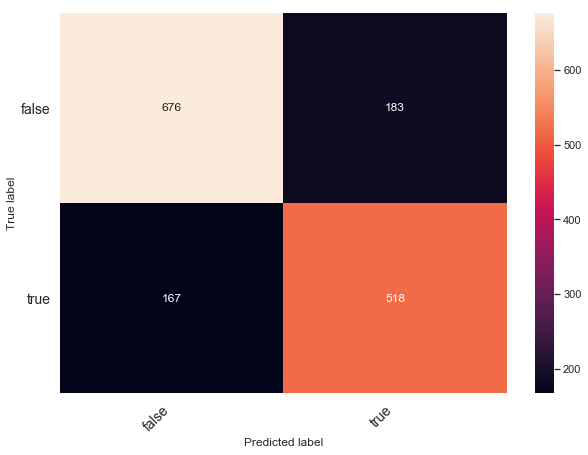

In [69]:
X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore, "initialScore.eps")

## One hot encode the dataframe before the pipeline

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__C': 3.6787189760095567, 'classifier__penalty': 'l2'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       676       183
pos       163       522
             precision    recall  f1-score   support

      False       0.81      0.79      0.80       859
       True       0.74      0.76      0.75       685

avg / total       0.78      0.78      0.78      1544



C:\Users\nathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


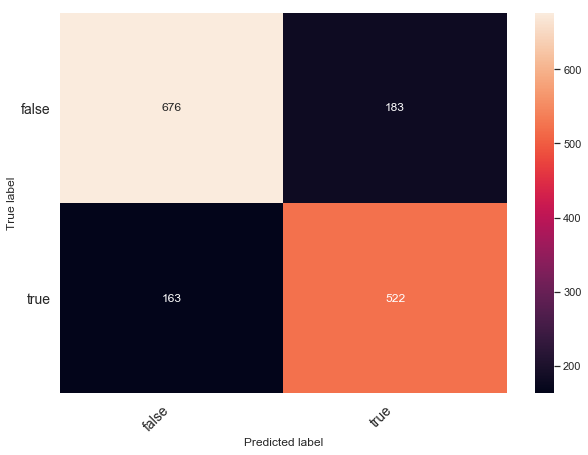

In [70]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Remove Skew on amount columns

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__C': 2.1380727166935083, 'classifier__penalty': 'l1'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       719       140
pos       179       506
             precision    recall  f1-score   support

      False       0.80      0.84      0.82       859
       True       0.78      0.74      0.76       685

avg / total       0.79      0.79      0.79      1544



C:\Users\nathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


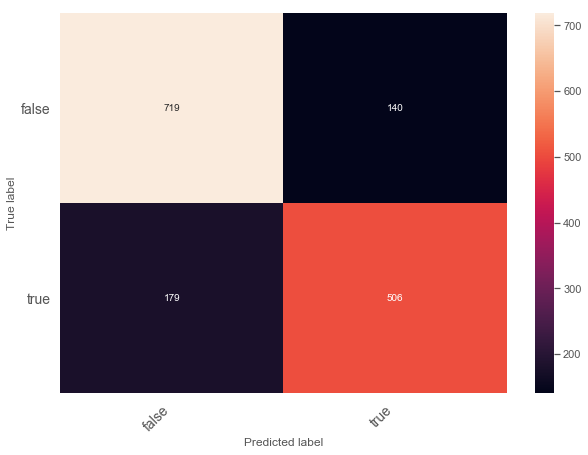

In [162]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew))
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# PCA

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__C': 0.4472820858534057, 'classifier__penalty': 'l2', 'pca__n_components': None, 'pca__whiten': True}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       726       133
pos       198       487
             precision    recall  f1-score   support

      False       0.79      0.85      0.81       859
       True       0.79      0.71      0.75       685

avg / total       0.79      0.79      0.78      1544



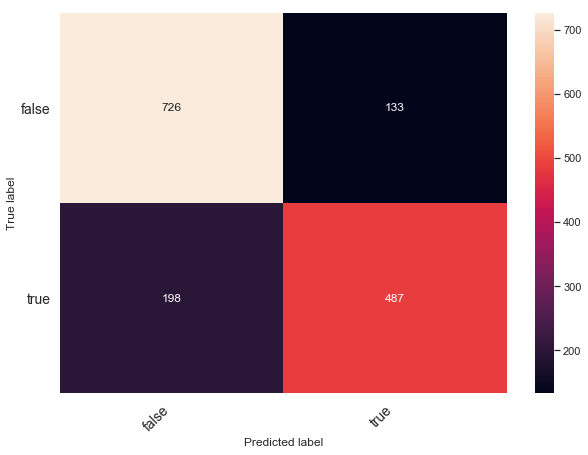

In [175]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
pca = decomposition.PCA(n_components=0.5, whiten=False)
param_grid = [
    {
        'reduceDimensions__n_components': (0.5,0.6, 0.7, 0.8,0.9,None),
        'reduceDimensions__whiten':(True,False),
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew))
])
clfPipeline = Pipeline([
    ('scaler',RobustScaler()),
    ('reduceDimensions', pca),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Feature selection

In [217]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
oneHotDataFrame.describe()

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64


,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,subCountryArea_North West,subCountryArea_Northern Ireland,subCountryArea_Scotland,subCountryArea_South East,subCountryArea_South West,subCountryArea_Wales,subCountryArea_West Midlands,subCountryArea_Yorkshire and the Humber,subCountryArea_none,subCountryArea_nan
count,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,...,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.0
mean,46900.834474,8199.874506,1091.890119,2638.875297,1719.273641,2563.909930,185.912380,62.047476,62.586826,201.173556,...,0.222412,0.028657,0.048760,0.113345,0.076775,0.048760,0.093028,0.036356,0.053251,0.0
std,67281.977821,13508.391594,2142.141606,4175.236029,4170.699589,6703.879866,941.121206,46.324495,90.800377,1290.280499,...,0.415911,0.166858,0.215388,0.317048,0.266263,0.215388,0.290503,0.187194,0.224557,0.0
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,3808.750000,657.000000,149.000000,240.000000,0.000000,0.000000,0.000000,22.000000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,11919.500000,2650.000000,310.000000,1000.000000,0.000000,121.415000,0.000000,54.000000,41.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,38661.000000,9256.892500,897.000000,3150.000000,964.875000,2123.912500,0.000000,96.000000,67.250000,1.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,215093.000000,227470.154000,35128.470000,79443.780000,39997.720000,169304.310000,19850.000000,197.000000,1258.000000,64171.440000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
# Test classifiers

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 5, 'classifier__max_iter': 500, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       758       101
pos       215       470
             precision    recall  f1-score   support

      False       0.78      0.88      0.83       859
       True       0.82      0.69      0.75       685

avg / total       0.80      0.80      0.79      1544



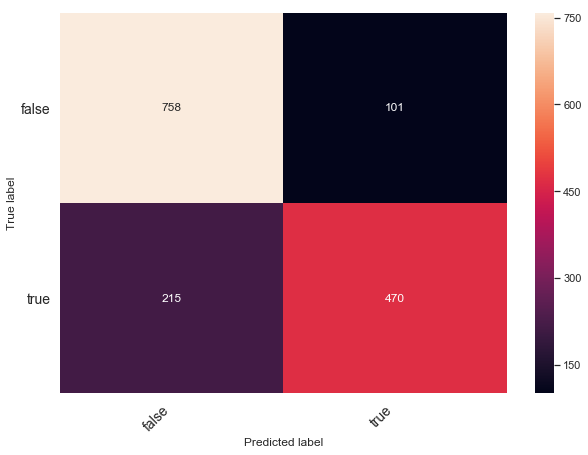

In [238]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
#pca = decomposition.PCA(n_components= None, whiten= True)
n_features_to_test = np.arange(1, 11)
reduceFeatures = (2,4, 6, 8,10,12,14,16,18,20,22,24,26,28,30)
percentageFeatures = (0.5,0.6, 0.7, 0.8,0.9,None)
alpha_to_test = 2.0**np.arange(-6, +6)
lrPenatlies = ['l1', 'l2']
scalersToTest = [StandardScaler(), RobustScaler(), QuantileTransformer()]
classifiersToTest = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=30),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

param_grid = [
    #'classifier__n_estimators': [10, 100, 1000], 
    #'classifier__max_features': [5, 10, 20],
    #{
        #'classifier':classifiersToTest,
        #'scaler': scalersToTest,
        #'reduceDimensions': [PCA()],
        #'reduceDimensions__n_components': percentageFeatures,
        #'reduceDimensions__whiten':(True,False)
    #},
    #{
        #'classifier':classifiersToTest,
        #'scaler': scalersToTest,
        #'reduceDimensions': [SelectKBest(f_classif)], # ANOVA (f_classif) scoring
        #'reduceDimensions__k': reduceFeatures
    #}
    {
        'classifier__activation': ["identity", "logistic", "tanh", "relu"],
        'classifier__solver': ['lbfgs'], 
        'classifier__max_iter': [500,1000,1500], 
        'classifier__alpha': 10.0 ** -np.arange(1, 7), 
        'classifier__hidden_layer_sizes':np.arange(5, 12), 
        'classifier__random_state':[0,1,2,3,4,5,6,7,8,9]
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew)),
])
clfPipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reduceDimensions', PCA()),
    #('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
    #('classifier', RandomForestClassifier(n_estimators=1000))
    ('classifier', MLPClassifier(alpha=1))
])
#MLPClassifier(alpha=1)

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 21
Best params for precision_score
{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 11, 'classifier__max_iter': 100, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       760        99
pos       184       501
             precision    recall  f1-score   support

      False       0.81      0.88      0.84       859
       True       0.83      0.73      0.78       685

avg / total       0.82      0.82      0.81      1544



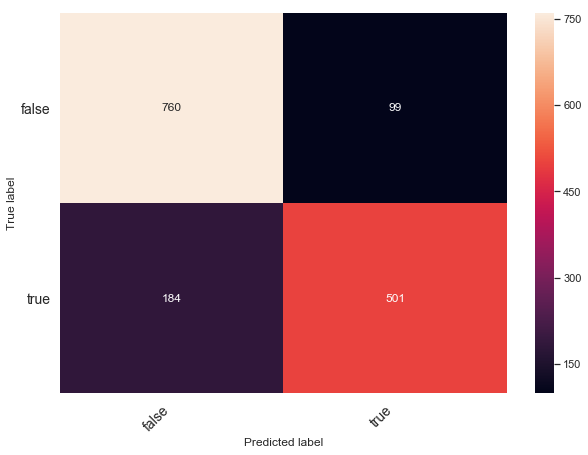

In [265]:
X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)
refitScore = 'precision_score'

param_grid = [
    {
        'classifier__activation': ["tanh"],
        'classifier__solver': ['lbfgs'], 
        'classifier__max_iter': [100,200,300,400,500], #200 giving a better score
        'classifier__alpha': [1e-06], 
        'classifier__hidden_layer_sizes':[11], # changed from 5 after manual intervention
        'classifier__random_state':[3]
    }
]
#{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 5, 'classifier__max_iter': 500, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew)),
])
clfPipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reduceDimensions', PCA()),
    ('classifier', MLPClassifier(alpha=1e-06))
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Improving the True->False score

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 21
Best params for precision_score
{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 11, 'classifier__max_iter': 100, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       742       117
pos       183       502
             precision    recall  f1-score   support

      False       0.80      0.86      0.83       859
       True       0.81      0.73      0.77       685

avg / total       0.81      0.81      0.80      1544



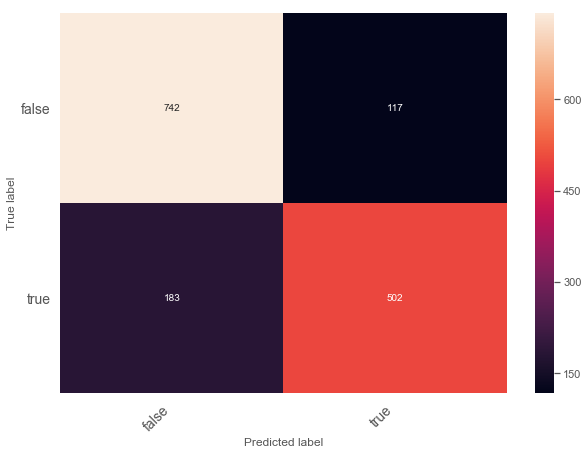

In [296]:
X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)
refitScore = 'precision_score'

param_grid = [
    {
        'classifier__activation': ["tanh"],
        'classifier__solver': ['lbfgs'], 
        'classifier__max_iter': [100], #after manual tweaking with the hidden layer size
        'classifier__alpha': [1e-06], 
        'classifier__hidden_layer_sizes':[11], # changed from 5 after manual intervention
        'classifier__random_state':[3]
    }
]
#{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 5, 'classifier__max_iter': 500, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew Right value cols',DFTransform(RemoveSkew)),
    #Removing this is important, causes worse prediction, work on col...
    #('Remove Left skew column', DFTransform(lambda X: X.drop(['avgDaysToPay'], axis=1)))
    #('Remove skew Left value cols',DFTransform(RemoveLeftSkew))
])
clfPipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reduceDimensions', PCA()),
    ('classifier', MLPClassifier())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Skew of amount data

In [282]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
matplotlib.style.use('ggplot')

skewColumns = dataFrame.skew(numeric_only="true")
skewRightColumns = skewColumns[lambda x : (x > 0.25)]
skewLeftColumns = skewColumns[lambda x : (x < -0.25)]
print(f"Skew right columns: {skewRightColumns}")
print("")
print(f"Skew left columns: {skewLeftColumns}")

Skew right columns: customerId               1.590838
amountTotal              3.609492
salesTotal               4.317364
annualTotal              4.863567
monthlyTotalProduct1     3.685016
monthlyTotalProduct2     7.965091
extraItemsTotal          9.006699
monthsSinceStarted       0.687213
avgDaysToPay             4.997191
creditedAmount          31.048405
hasProduct1              0.401472
hasProduct4              3.529746
hasProduct5             68.381284
hasProduct7             18.892434
hasProduct8             12.368155
hasProduct9             68.381284
hasProduct10             2.000120
hasProduct11             8.659933
hasProduct12             0.895294
dtype: float64

Skew left columns: hasProduct2   -0.471209
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002801312E550>,
      dtype=object)

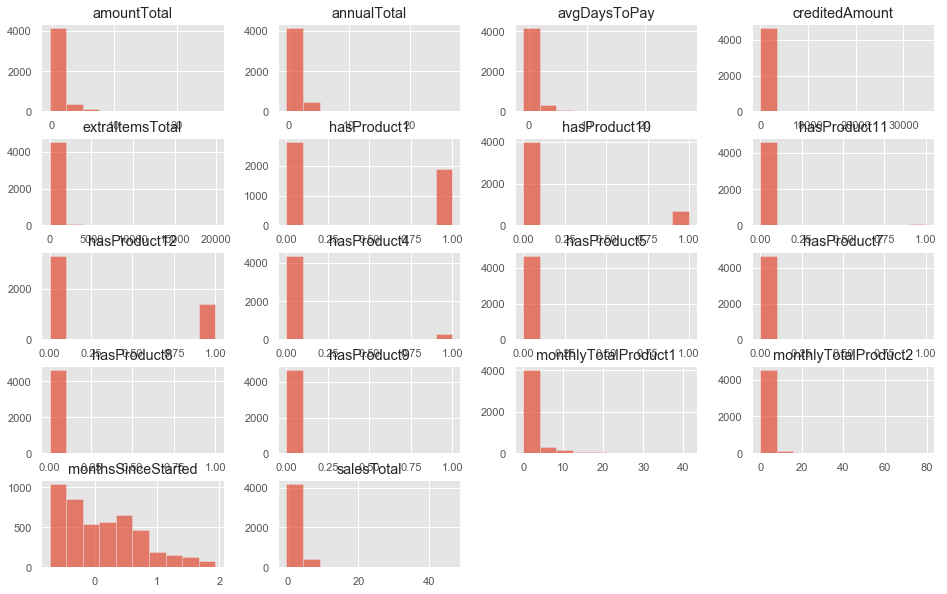

In [308]:
#Get the skewed cols
scaler = RobustScaler()
skewRightDf = dataFrame[skewRightColumns.index]
skewRightDf = skewRightDf.drop([customerIdKey], axis=1)
skewRightDf[skewRightDf.columns] = scaler.fit_transform(skewRightDf[skewRightDf.columns])
skewRightDf.hist(alpha=0.7, figsize=(16, 10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676 entries, 0 to 4675
Data columns (total 19 columns):
customerId              4676 non-null int64
amountTotal             4676 non-null float64
salesTotal              4676 non-null float64
annualTotal             4676 non-null float64
monthlyTotalProduct1    4676 non-null float64
monthlyTotalProduct2    4676 non-null float64
extraItemsTotal         4676 non-null float64
monthsSinceStarted      4676 non-null int64
avgDaysToPay            4676 non-null int64
creditedAmount          4676 non-null float64
hasProduct1             4676 non-null bool
hasProduct4             4676 non-null bool
hasProduct5             4676 non-null bool
hasProduct7             4676 non-null bool
hasProduct8             4676 non-null bool
hasProduct9             4676 non-null bool
hasProduct10            4676 non-null bool
hasProduct11            4676 non-null bool
hasProduct12            4676 non-null bool
dtypes: bool(9), float64(7), int64(3)
memory usage: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280146C1FD0>,
      dtype=object)

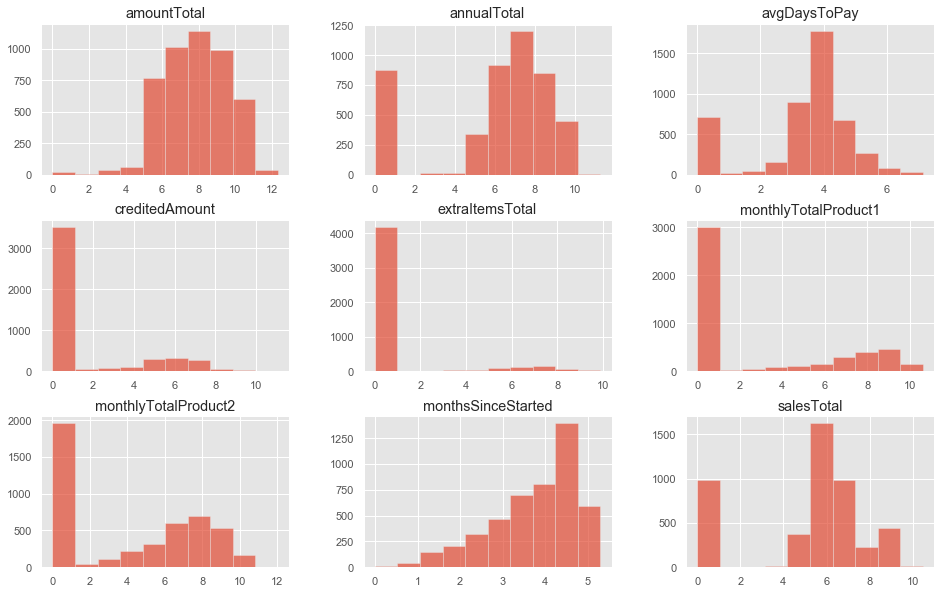

In [309]:
#Log transform
skewRightDf = dataFrame[skewRightColumns.index]
skewRightDf = skewRightDf.drop([customerIdKey], axis=1)
print(dataFrame[skewRightColumns.index].info())
# 1+ to get rid of -inf value
skewRightDfLog = np.log(1+skewRightDf.select_dtypes(include=['float64','int64']))
skewRightDfLog.hist(alpha=0.7, figsize=(16, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280130C2668>]],
      dtype=object)

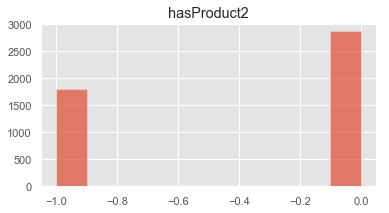

In [307]:
matplotlib.style.use('ggplot')
skewLeftDf = dataFrame.loc[:,skewLeftColumns.index]
skewLeftDf.loc[:,skewLeftDf.columns] = scaler.fit_transform(skewLeftDf.loc[:,skewLeftDf.columns])
skewLeftDf.hist(alpha=0.7, figsize=(6, 3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000280794C1358>,
      dtype=object)

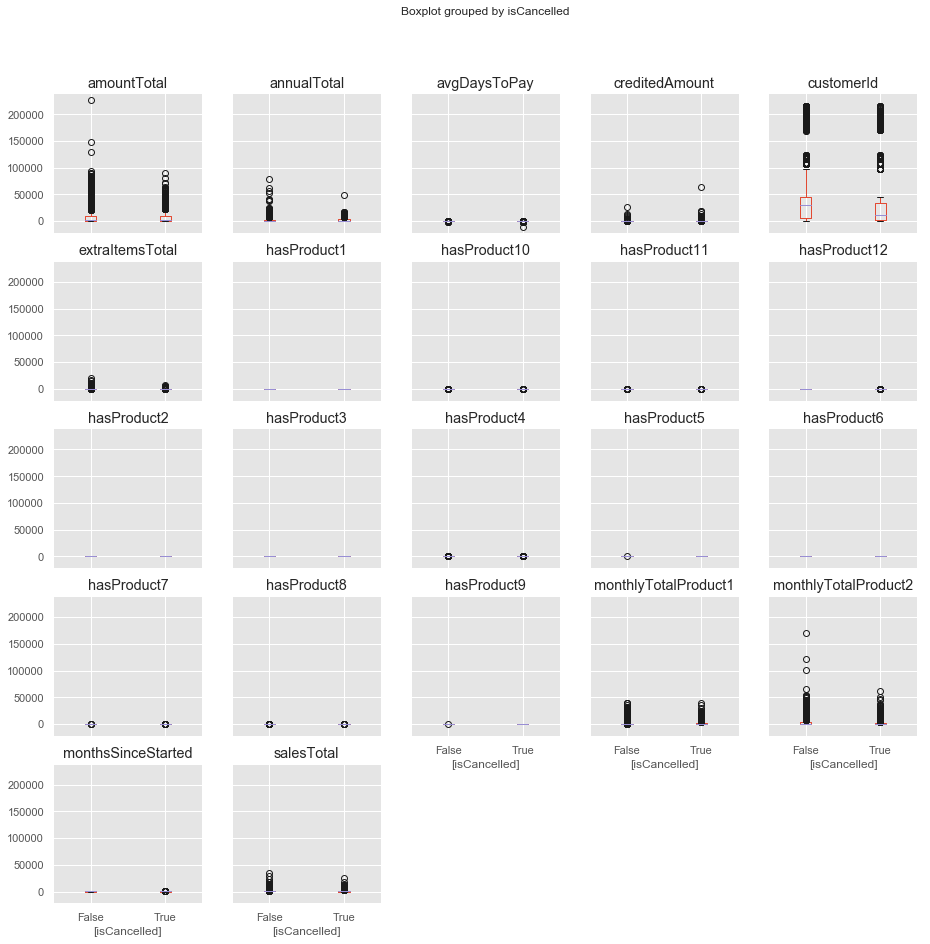

In [71]:
# log tranform all right skewed cols:
#logDfRightTest = np.log2(1+skewRightDf['amountTotal'])
#skewRightDf.hist(alpha=0.7, figsize=(6, 3))
dataFrame.boxplot(by= isCancelledKey,figsize= (15,15))   

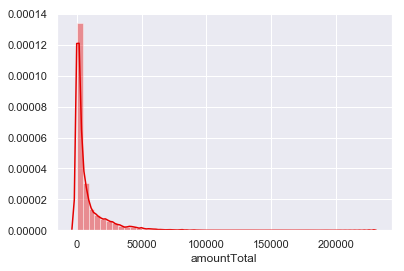

In [34]:
sns.distplot(dataFrame['amountTotal'],kde=True)

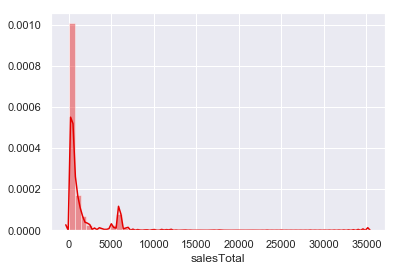

In [35]:
sns.distplot(dataFrame['salesTotal'],kde=True)

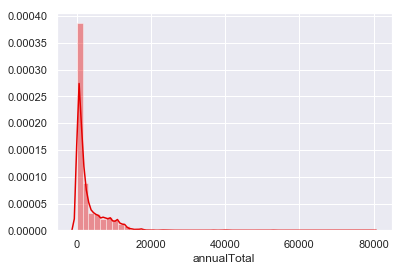

In [36]:
sns.distplot(dataFrame['annualTotal'],kde=True)

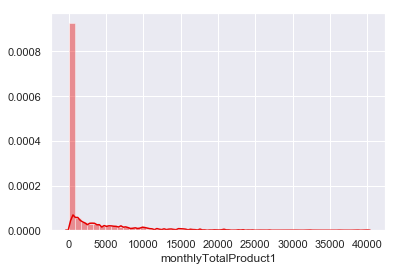

In [37]:
sns.distplot(dataFrame['monthlyTotalProduct1'],kde=True)

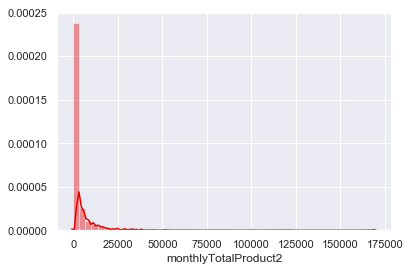

In [38]:
sns.distplot(dataFrame['monthlyTotalProduct2'],kde=True)

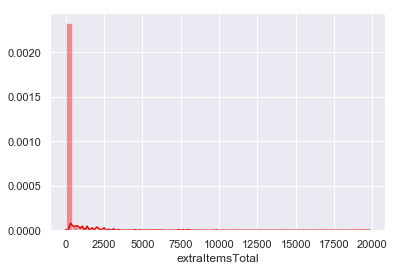

In [39]:
sns.distplot(dataFrame['extraItemsTotal'],kde=True)

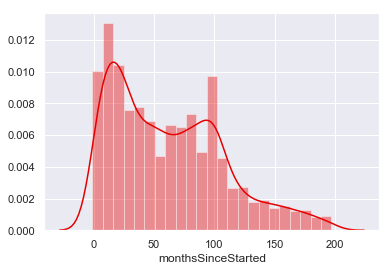

In [40]:
sns.distplot(dataFrame['monthsSinceStarted'],kde=True)

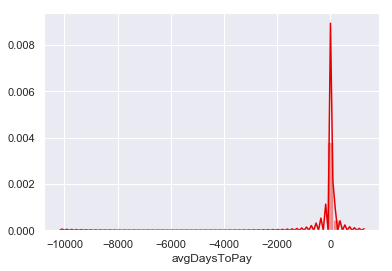

In [41]:
sns.distplot(dataFrame['avgDaysToPay'],kde=True)

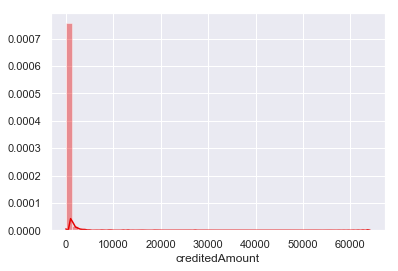

In [42]:
sns.distplot(dataFrame['creditedAmount'],kde=True)

# Distrubution of catagorical variables

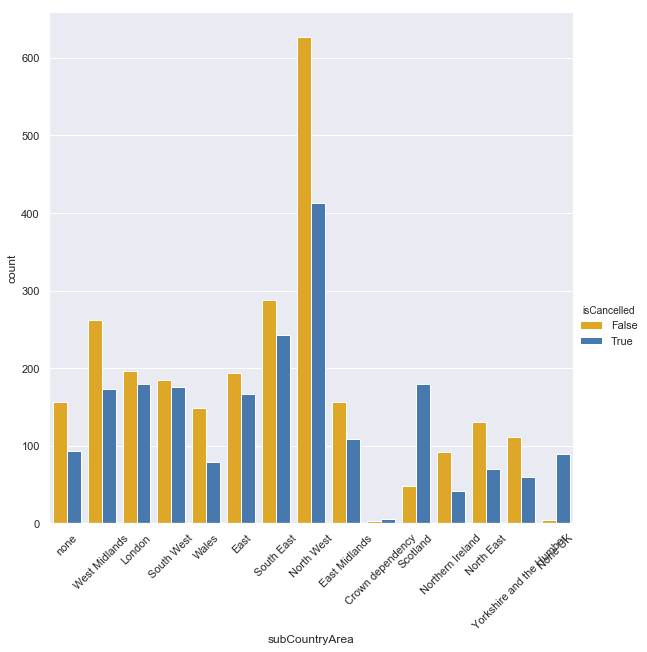

In [72]:
fig = sns.catplot(x=subCountryKey,height=8, hue=isCancelledKey, kind="count", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('catagoricalSubCountryArea.eps', format='eps')
#[adminAreaKey, subCountryKey,countryKey]

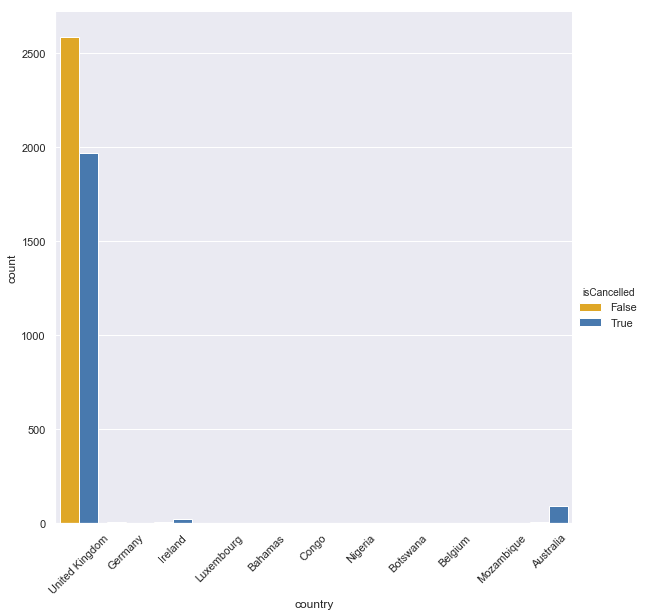

In [74]:
fig = sns.catplot(x=countryKey,height=8, hue=isCancelledKey, kind="count", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('catagoricalCountry.eps', format='eps')
#[adminAreaKey, subCountryKey,countryKey]

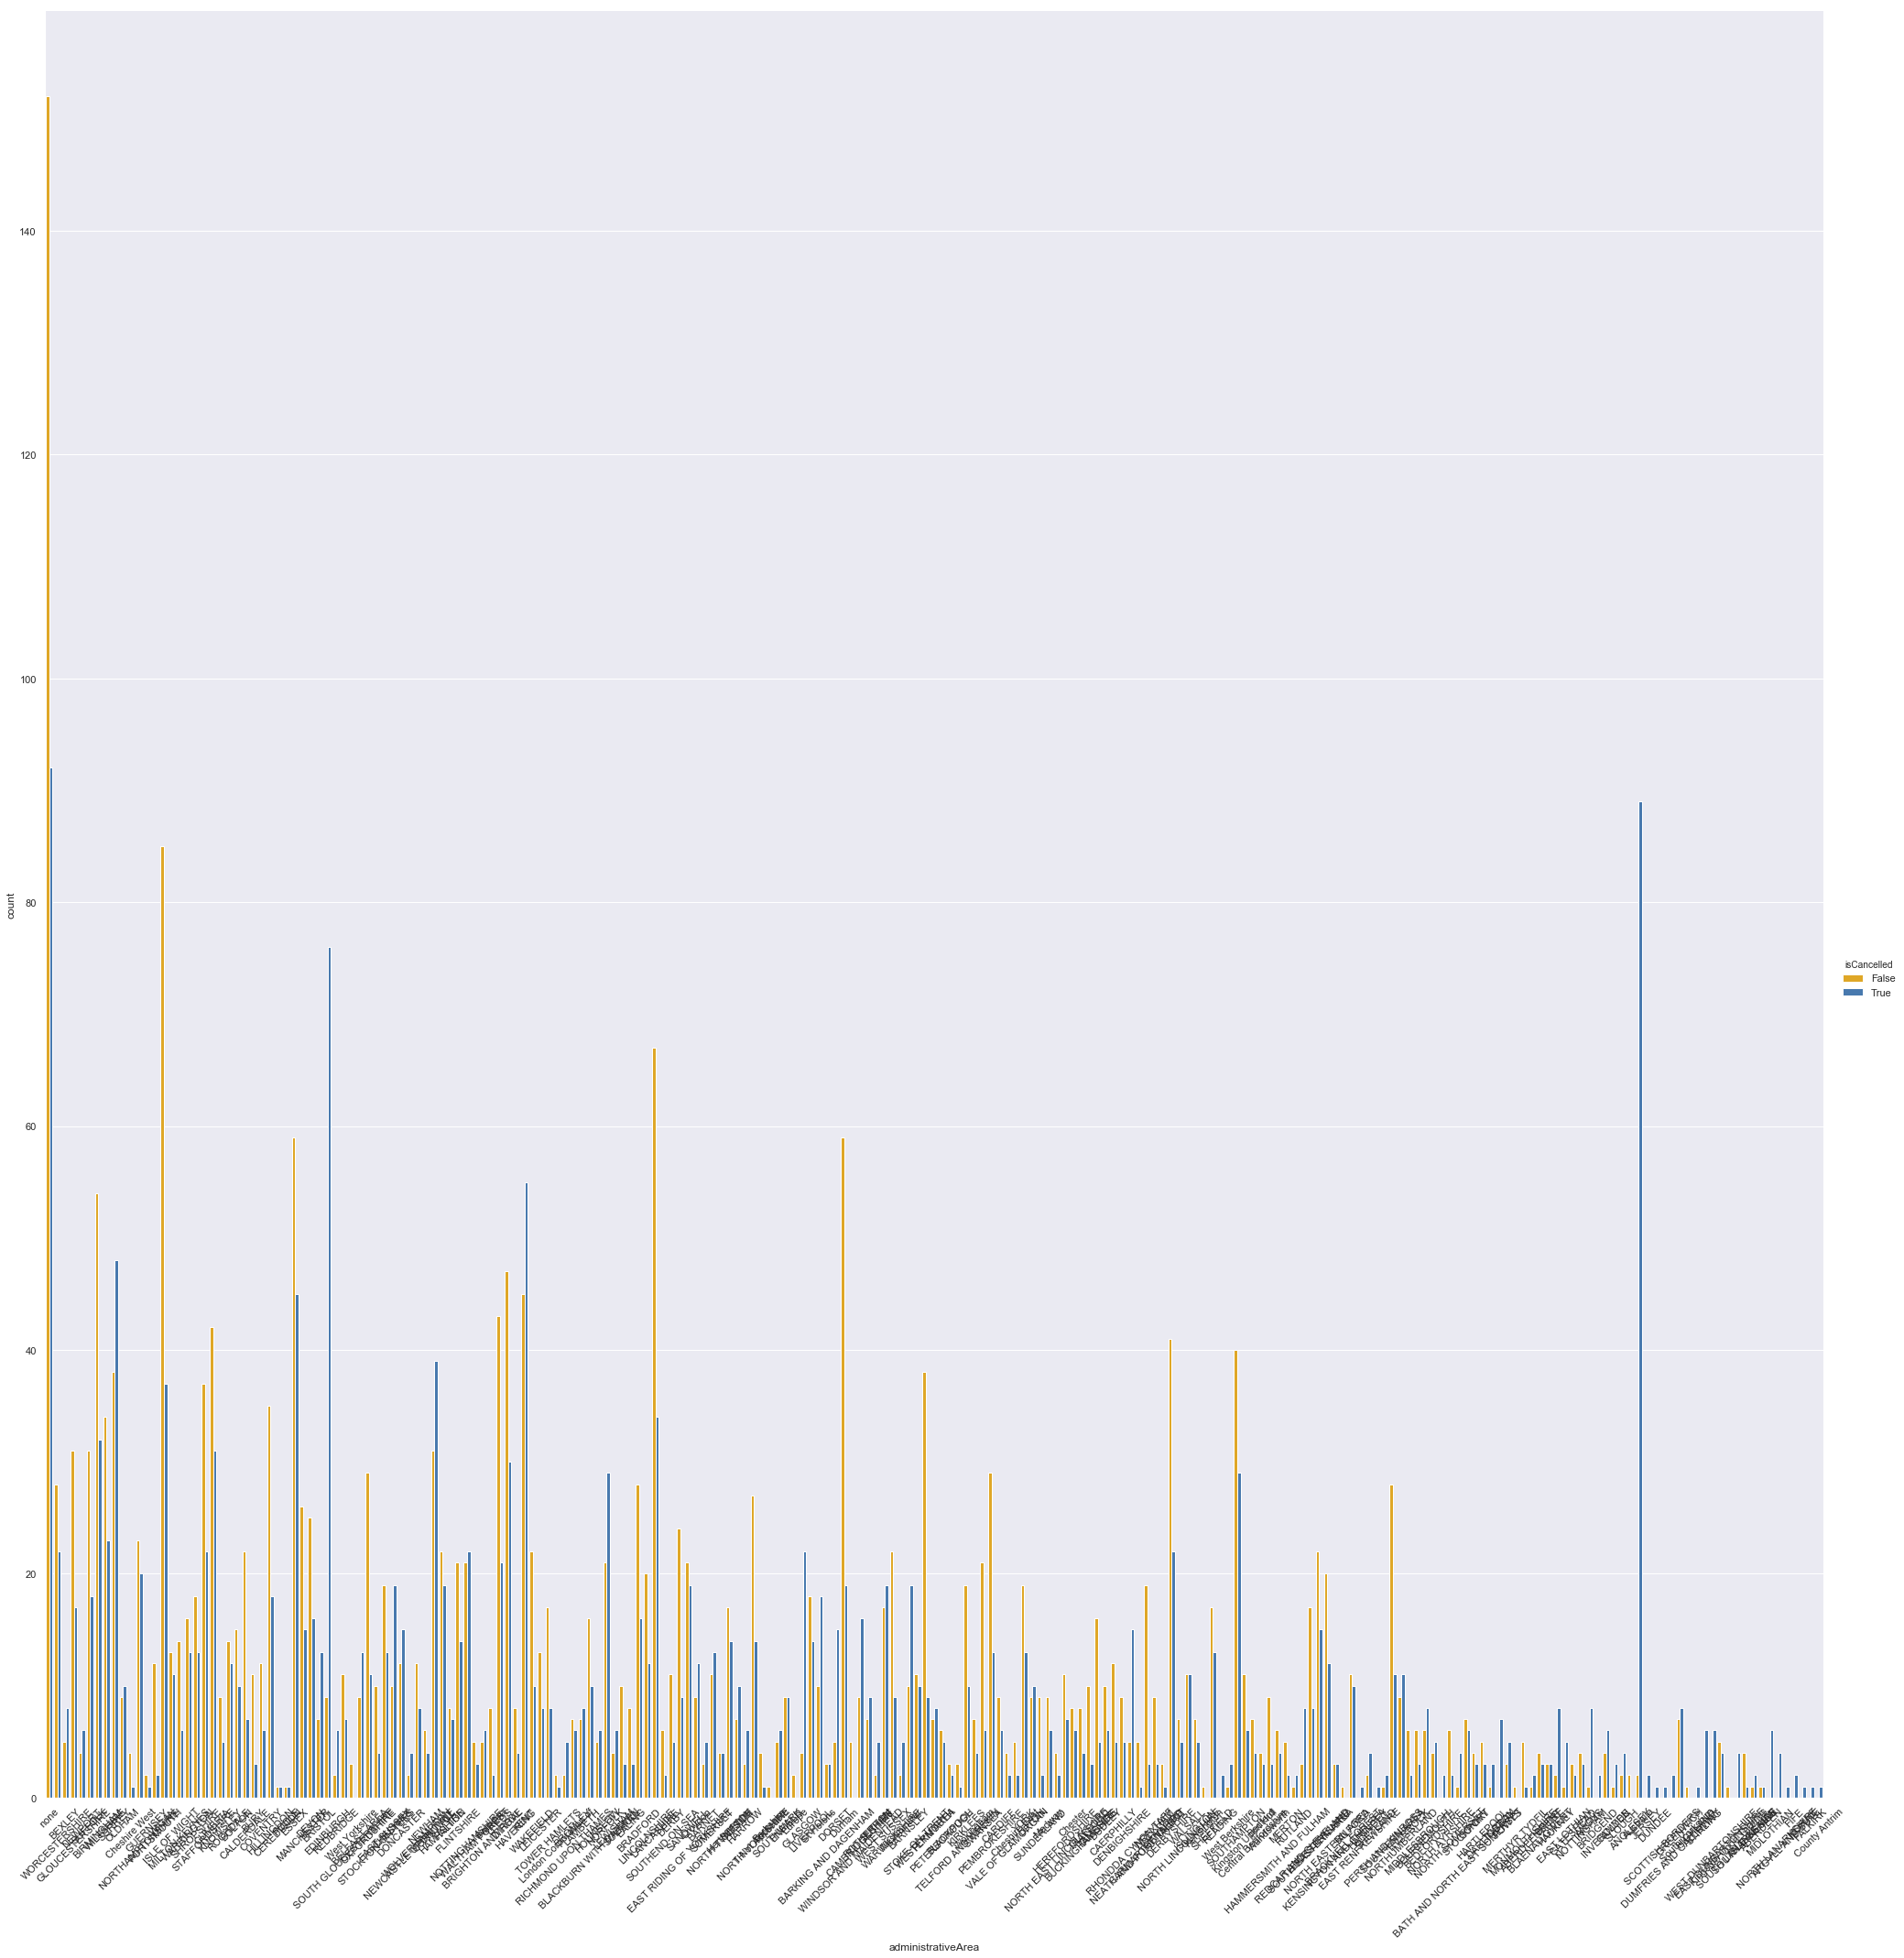

In [75]:
fig = sns.catplot(x=adminAreaKey,height=28, hue=isCancelledKey, kind="count", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('catagoricalAdminArea.eps', format='eps')

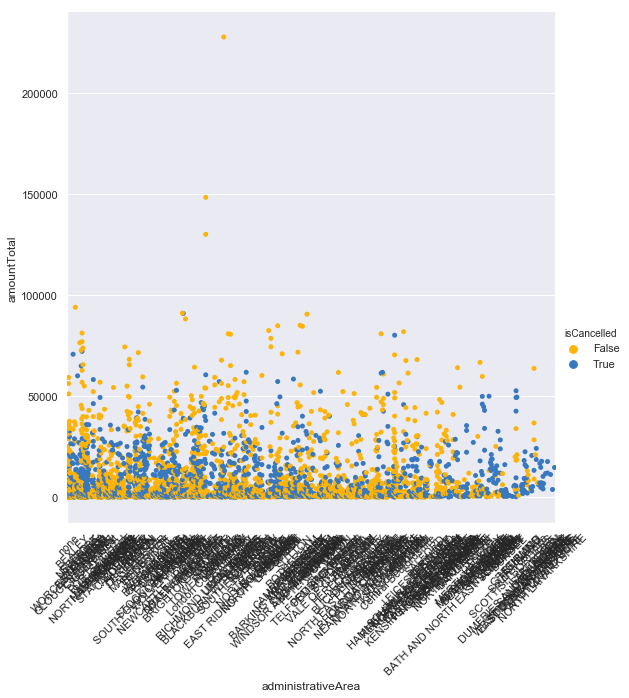

In [76]:
fig = sns.catplot(x=adminAreaKey, y='amountTotal', height=8, hue=isCancelledKey, kind="swarm", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('adminAreaOverAmountTotal.eps', format='eps')
#[adminAreaKey, subCountryKey,countryKey]

# References
Fine tuning a classifier in scikit-learn
- https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
- conditional-probability coding (CP-coding) - https://medium.com/airbnb-engineering/designing-machine-learning-models-7d0048249e69
- feature scaleing options http://benalexkeen.com/feature-scaling-with-scikit-learn/